## Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import requests
from enum import Enum
import warnings as wrn
import matplotlib.pyplot as plt

class ActionType(Enum):
    BUY = 1
    DONOTHING = 0
    SELL = -1

#### Function to make an API call to Binance

In [2]:
def make_api_call(base_url, endpoint="", method="GET", **kwargs):
    # Construct the full URL
    full_url = f'{base_url}{endpoint}'

    # Make the API call
    response = requests.request(method=method, url=full_url, **kwargs)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        # If the request was not successful, raise an exception with the error message
        raise Exception(f'API request failed with status code {response.status_code}: {response.text}')

In [3]:
def get_binance_historical_data(symbol, interval, start_date, end_date):
    
    # define basic parameters for call
    base_url = 'https://fapi.binance.com'
    endpoint = '/fapi/v1/klines'
    method = 'GET'
    
    # Set the start time parameter in the params dictionary
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': 1500,
        'startTime': start_date, # Start time in milliseconds
        'endTime': end_date # end time in milliseconds
    }

    # Make initial API call to get candles
    response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)
    
    # initalize candles data
    candles_data = []

    # Append the received candles to the list
    candles_data.extend(response.json())

    # Update the start time for the next API call
    params['startTime'] = candles_data[-1][0] + 1 # last candle open_time + 1ms    

    while len(response.json()) > 0:
        # Make the next API call
        response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)

        # Append the received candles to the list
        candles_data.extend(response.json())

        # Update the start time for the next API call
        params['startTime'] = candles_data[-1][0] + 1 # last candle open_time + 1ms
        
        if params['startTime'] > params['endTime']:
            break

    # Wrap the candles data as a pandas DataFrame
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
               'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    dtype={
    'open_time': 'datetime64[ms, Asia/Jerusalem]',
    'open': 'float64',
    'high': 'float64',
    'low': 'float64',
    'close': 'float64',
    'volume': 'float64',
    'close_time': 'datetime64[ms, Asia/Jerusalem]',
    'quote_asset_volume': 'float64',
    'number_of_trades': 'int64',
    'taker_buy_base_asset_volume': 'float64',
    'taker_buy_quote_asset_volume': 'float64',
    'ignore': 'float64'
    }
    
    df = pd.DataFrame(candles_data, columns=columns)
    df = df.astype(dtype)

    return df

### 2. Getting the data

In [4]:
symbol = 'BTCUSDT'
interval = '30m'
start_date = int(datetime(year=2023, month=1, day=1).timestamp() * 1000)
end_date = int(datetime(year=2024, month=1, day=1).timestamp() * 1000)

btcusdt_df = get_binance_historical_data(symbol, interval, start_date, end_date)[['open_time', 'open', 'high', 'low', 'close', 'volume']]
btcusdt_df

,open_time,open,high,low,close,volume
0,2023-01-01 00:00:00+02:00,16544.0,16565.1,16496.0,16540.7,7737.533
1,2023-01-01 00:30:00+02:00,16540.8,16550.8,16461.8,16515.1,8929.034
2,2023-01-01 01:00:00+02:00,16515.1,16524.6,16483.1,16520.9,5215.713
3,2023-01-01 01:30:00+02:00,16520.9,16546.9,16516.5,16537.6,3127.373
4,2023-01-01 02:00:00+02:00,16537.5,16540.9,16513.4,16539.4,2832.734
...,...,...,...,...,...,...
17516,2023-12-31 22:00:00+02:00,42659.9,42724.5,42600.0,42627.2,2559.181
17517,2023-12-31 22:30:00+02:00,42627.2,42662.5,42543.3,42599.1,2171.755
17518,2023-12-31 23:00:00+02:00,42599.2,42717.0,42586.7,42674.8,1468.758
17519,2023-12-31 23:30:00+02:00,42674.8,42689.1,42558.2,42558.9,2325.252


### 3. Calculate the indicators
#### **UTBot**
##### Helper Functions

In [5]:
def TR(close: pd.Series, high: pd.Series, low: pd.Series) -> pd.Series:
    return (high.where(high > close.shift(1), close.shift(1)) - low.where(low < close.shift(1), close.shift(1)))

def ATR(TRsrs: pd.Series, atr_length: int) -> pd.Series:
    return TRsrs.rolling(window = atr_length).mean()

def crossOver(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a > b) & (a.shift(1) < b.shift(1))

##### Main Function

Because the presentor used 2 UTBot indicators we decided to make the UTBot implementation a little more customizable

Here the default settings are the same as the presentor has set in the video

In [6]:
def UTBot(close, high, low, buyKeyVal = 2, buyATRlen = 300, sellKeyVal = 2, sellATRlen = 1) -> pd.Series:
    # calculating the thresholds and initializing the trailing stops
    lossThrshBuy = buyKeyVal * ATR(TR(close, high, low), buyATRlen)
    lossThrshSell = sellKeyVal * ATR(TR(close, high, low), sellATRlen)
    trailStopBuy = 0 * lossThrshBuy
    trailStopSell = 0 * lossThrshSell

    # calculating the trailing stops
    for i in range(1, len(trailStopBuy)):
        if (close[i] > trailStopBuy[i - 1]) & (close[i - 1] > trailStopBuy[i - 1]):
            trailStopBuy[i] = max(trailStopBuy[i - 1], close[i] - lossThrshBuy[i])
        elif (close[i] < trailStopBuy[i - 1]) & (close[i - 1] < trailStopBuy[i - 1]):
            trailStopBuy[i] = min(trailStopBuy[i - 1], close[i] + lossThrshBuy[i])
        elif (close[i] > trailStopBuy[i - 1]):
            trailStopBuy[i] = close[i] - lossThrshBuy[i]
        else:
            trailStopBuy[i] = close[i] + lossThrshBuy[i]

        if (close[i] > trailStopSell[i - 1]) & (close[i - 1] > trailStopSell[i - 1]):
            trailStopSell[i] = max(trailStopSell[i - 1], close[i] - lossThrshSell[i])
        elif (close[i] < trailStopSell[i - 1]) & (close[i - 1] < trailStopSell[i - 1]):
            trailStopSell[i] = min(trailStopSell[i - 1], close[i] - lossThrshSell[i])
        elif (close[i] > trailStopSell[i - 1]):
            trailStopSell[i] = close[i] - lossThrshSell[i]
        else:
            trailStopSell[i] = close[i] + lossThrshSell[i]

    # finding the buy and sell signals    
    above = crossOver(close, trailStopBuy)
    below = crossOver(trailStopSell, close)
    Action = np.select([above, below], [ActionType.BUY, ActionType.SELL], default = ActionType.DONOTHING)
    return Action

#### **STC**

##### Helping Functions

In [7]:
def SmoothSrs(srs, smoothFact):
    smoothed_srs = srs.copy()
    for i in range(1, len(smoothed_srs)):
        if np.isnan(smoothed_srs[i-1]):
            smoothed_srs[i] = srs[i]
        else:
            smoothed_srs[i] = smoothed_srs[i-1] + smoothFact * (srs[i] - smoothed_srs[i-1])
    return smoothed_srs

def normNsmooth(srs, stcLen, smoothFact):
    # finding the lowest and highest range
    lowest = srs.rolling(stcLen).min()
    highestRange = srs.rolling(stcLen).max() - lowest
    
    # normalizing srs
    normalizedsrs = srs.copy()
    normalizedsrs[highestRange > 0] = ((srs - lowest) / highestRange * 100)*(highestRange > 0)
    normalizedsrs[highestRange <= 0] = np.nan
    normalizedsrs.ffill(inplace = True)
    
    # smoothing the srs
    return SmoothSrs(normalizedsrs, smoothFact)

##### Main Function
Default settings are the same as done in the video

In [8]:
def stcOsilator(srs, fastLen = 27, slowLen = 50, stcLen = 80, smoothFact = 0.5, sellThrsh = 75, buyThrsh = 25):
    # ema calculation for fast and slow length's
    fast_ema = srs.ewm(span = fastLen).mean()
    slow_ema = srs.ewm(span = slowLen).mean()

    # MacdDiff calculation and smoothing
    MacdDiff = fast_ema - slow_ema
    smoothedMacd = normNsmooth(MacdDiff, stcLen, smoothFact)
    FinalSTC = normNsmooth(smoothedMacd, stcLen, smoothFact)
    
    above = (FinalSTC > sellThrsh)
    descent = (FinalSTC < FinalSTC.shift(1)).ffill(inplace = False)
    below = (FinalSTC < buyThrsh)
    rise = (FinalSTC > FinalSTC.shift(1)).ffill(inplace = False)

    Action = np.select([above & descent, below & rise], [ActionType.SELL, ActionType.BUY], default = ActionType.DONOTHING)

    return Action, FinalSTC

### Indicators conclusion
At the end of the day these 2 indicators give safe and relatively certain signals to Buy or Sell.

In [9]:
wrn.filterwarnings('ignore')

btcusdt_df['UTBot_indicator'] = UTBot(close = btcusdt_df.close, high = btcusdt_df.high, low = btcusdt_df.low)
btcusdt_df['STC_indicator'], btcusdt_df['STC_indicatorValue'] = stcOsilator(srs = btcusdt_df.close)
btcusdt_df['cumulative_signal'] = np.where((btcusdt_df['UTBot_indicator'] != btcusdt_df['STC_indicator']), ActionType.DONOTHING, btcusdt_df['UTBot_indicator'])
btcusdt_df['curr_last_signal'] = btcusdt_df.cumulative_signal

btcusdt_df.curr_last_signal.iloc[0] = ActionType.DONOTHING
for i in range(1, btcusdt_df.shape[0]):
    if btcusdt_df.cumulative_signal.iloc[i] == ActionType.BUY:
        btcusdt_df.curr_last_signal.iloc[i] = ActionType.BUY
    elif (btcusdt_df.cumulative_signal.iloc[i] == ActionType.SELL) & (btcusdt_df.curr_last_signal.iloc[i - 1] != ActionType.DONOTHING):
        btcusdt_df.curr_last_signal.iloc[i] = ActionType.SELL
    else:
        btcusdt_df.curr_last_signal.iloc[i] = btcusdt_df.curr_last_signal.iloc[i - 1]

btcusdt_df['Final_signal'] = np.where(btcusdt_df.curr_last_signal != btcusdt_df.curr_last_signal.shift(1), btcusdt_df.curr_last_signal, ActionType.DONOTHING)

# to make sure that the final signal given is a sell signal
if (btcusdt_df.curr_last_signal.iloc[btcusdt_df.shape[0] - 1] == ActionType.BUY) & (btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] == ActionType.DONOTHING):
    btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] = ActionType.SELL
elif btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] == ActionType.BUY:
    btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] = ActionType.DONOTHING

btcusdt_df.drop(columns = ['cumulative_signal', 'curr_last_signal'], inplace = True)

btcusdt_df

,open_time,open,high,low,close,volume,UTBot_indicator,STC_indicator,STC_indicatorValue,Final_signal
0,2023-01-01 00:00:00+02:00,16544.0,16565.1,16496.0,16540.7,7737.533,ActionType.DONOTHING,ActionType.DONOTHING,0.000000,ActionType.DONOTHING
1,2023-01-01 00:30:00+02:00,16540.8,16550.8,16461.8,16515.1,8929.034,ActionType.DONOTHING,ActionType.DONOTHING,-0.054519,ActionType.DONOTHING
2,2023-01-01 01:00:00+02:00,16515.1,16524.6,16483.1,16520.9,5215.713,ActionType.DONOTHING,ActionType.DONOTHING,-0.109000,ActionType.DONOTHING
3,2023-01-01 01:30:00+02:00,16520.9,16546.9,16516.5,16537.6,3127.373,ActionType.DONOTHING,ActionType.BUY,-0.093982,ActionType.DONOTHING
4,2023-01-01 02:00:00+02:00,16537.5,16540.9,16513.4,16539.4,2832.734,ActionType.DONOTHING,ActionType.BUY,-0.026742,ActionType.DONOTHING
...,...,...,...,...,...,...,...,...,...,...
17516,2023-12-31 22:00:00+02:00,42659.9,42724.5,42600.0,42627.2,2559.181,ActionType.DONOTHING,ActionType.DONOTHING,98.543187,ActionType.DONOTHING
17517,2023-12-31 22:30:00+02:00,42627.2,42662.5,42543.3,42599.1,2171.755,ActionType.DONOTHING,ActionType.DONOTHING,98.562249,ActionType.DONOTHING
17518,2023-12-31 23:00:00+02:00,42599.2,42717.0,42586.7,42674.8,1468.758,ActionType.DONOTHING,ActionType.SELL,98.528401,ActionType.DONOTHING
17519,2023-12-31 23:30:00+02:00,42674.8,42689.1,42558.2,42558.9,2325.252,ActionType.DONOTHING,ActionType.SELL,98.060646,ActionType.DONOTHING


### 6. apply the strategy and its performance

In [10]:
# calculating strategy performance parameters
startBalance = 10000
btcusdt_df['balance'] = pd.Series(startBalance, index = btcusdt_df.index)
inout = 0
for i in range(1, btcusdt_df.shape[0]):
    btcusdt_df.balance.iloc[i] = btcusdt_df.balance.iloc[i - 1] + (btcusdt_df.close.iloc[i] - btcusdt_df.close.iloc[i - 1]) * inout
    if btcusdt_df.Final_signal.iloc[i] != ActionType.DONOTHING:
        inout = abs(inout - 1)
btcusdt_df['PortfolioPct'] = btcusdt_df.balance.pct_change()
btcusdt_df['cumulativePortfolioPct'] = (1 + btcusdt_df.PortfolioPct).cumprod() - 1
nCopleteXchg = btcusdt_df.Final_signal.value_counts().loc[ActionType.BUY]
nProfit = (btcusdt_df.balance[btcusdt_df.Final_signal == ActionType.SELL] > btcusdt_df.balance[btcusdt_df.Final_signal == ActionType.SELL].shift(1)).sum()

# strategy performance results
print(f'''Average Returns: {btcusdt_df.PortfolioPct.mean():.3%}
Returns Standrad Deviation: {btcusdt_df.PortfolioPct.std():.3%}
Overall Cumulative Net Returns: {btcusdt_df.cumulativePortfolioPct.iloc[-1]:.3%}

Total amount of exchanges (Buy & Sell): {nCopleteXchg}
Amount of Profitable Exchanges: {nProfit}

Precentage of Profitable Exchanges: {nProfit / nCopleteXchg:.3%}''')

Average Returns: 0.003%
Returns Standrad Deviation: 0.467%
Overall Cumulative Net Returns: 51.962%

Total amount of exchanges (Buy & Sell): 88
Amount of Profitable Exchanges: 49

Precentage of Profitable Exchanges: 55.682%


### 7. Changing a prameter

we chose to change the STC length

In [11]:
btcuParamChng_df = btcusdt_df.copy(deep=True).loc[:, ['open_time', 'open', 'high', 'low', 'close', 'volume']]

btcuParamChng_df['UTBot_indicator'] = UTBot(close = btcuParamChng_df.close, high = btcuParamChng_df.high, low = btcuParamChng_df.low)
btcuParamChng_df['STC_indicator'], btcuParamChng_df['STC_indicatorValue'] = stcOsilator(srs = btcuParamChng_df.close, stcLen = 90)
btcuParamChng_df['cumulative_signal'] = np.where((btcuParamChng_df['UTBot_indicator'] != btcuParamChng_df['STC_indicator']), ActionType.DONOTHING, btcuParamChng_df['UTBot_indicator'])
btcuParamChng_df['curr_last_signal'] = btcuParamChng_df.cumulative_signal

btcuParamChng_df.curr_last_signal.iloc[0] = ActionType.DONOTHING
for i in range(1, btcuParamChng_df.shape[0]):
    if btcuParamChng_df.cumulative_signal.iloc[i] == ActionType.BUY:
        btcuParamChng_df.curr_last_signal.iloc[i] = ActionType.BUY
    elif (btcuParamChng_df.cumulative_signal.iloc[i] == ActionType.SELL) & (btcuParamChng_df.curr_last_signal.iloc[i - 1] != ActionType.DONOTHING):
        btcuParamChng_df.curr_last_signal.iloc[i] = ActionType.SELL
    else:
        btcuParamChng_df.curr_last_signal.iloc[i] = btcuParamChng_df.curr_last_signal.iloc[i - 1]

btcuParamChng_df['Final_signal'] = np.where(btcuParamChng_df.curr_last_signal != btcuParamChng_df.curr_last_signal.shift(1), btcuParamChng_df.curr_last_signal, ActionType.DONOTHING)

# to make sure that the final signal given is a sell signal
if (btcuParamChng_df.curr_last_signal.iloc[btcuParamChng_df.shape[0] - 1] == ActionType.BUY) & (btcuParamChng_df.Final_signal.iloc[btcuParamChng_df.shape[0] - 1] == ActionType.DONOTHING):
    btcuParamChng_df.Final_signal.iloc[btcuParamChng_df.shape[0] - 1] = ActionType.SELL
elif btcuParamChng_df.Final_signal.iloc[btcuParamChng_df.shape[0] - 1] == ActionType.BUY:
    btcuParamChng_df.Final_signal.iloc[btcuParamChng_df.shape[0] - 1] = ActionType.DONOTHING

btcuParamChng_df.drop(columns = ['curr_last_signal', 'cumulative_signal'], inplace = True)

In [12]:
# calculating strategy performance parameters
btcuParamChng_df['balance'] = pd.Series(startBalance, index = btcuParamChng_df.index)
inout = 0
for i in range(1, btcuParamChng_df.shape[0]):
    btcuParamChng_df.balance.iloc[i] = btcuParamChng_df.balance.iloc[i - 1] + (btcuParamChng_df.close.iloc[i] - btcuParamChng_df.close.iloc[i - 1]) * inout
    if btcuParamChng_df.Final_signal.iloc[i] != ActionType.DONOTHING:
        inout = abs(inout - 1)
btcuParamChng_df['PortfolioPct'] = btcuParamChng_df.balance.pct_change()
btcuParamChng_df['cumulativePortfolioPct'] = (1 + btcuParamChng_df.PortfolioPct).cumprod() - 1
nCopleteXchgParamChng = btcuParamChng_df.Final_signal.value_counts().loc[ActionType.BUY]
nProfitParamChng = (btcuParamChng_df.balance[btcuParamChng_df.Final_signal == ActionType.SELL] > btcuParamChng_df.balance[btcuParamChng_df.Final_signal == ActionType.SELL].shift(1)).sum()

# strategy performance results
print(f'''Average Returns: {btcuParamChng_df.PortfolioPct.mean():.3%}
Returns Standrad Deviation: {btcuParamChng_df.PortfolioPct.std():.3%}
Overall Cumulative Net Returns: {btcuParamChng_df.cumulativePortfolioPct.iloc[-1]:.3%}

Total amount of exchanges (Buy & Sell): {nCopleteXchgParamChng}
Amount of Profitable Exchanges: {nProfitParamChng}

Precentage of Profitable Exchanges: {nProfitParamChng / nCopleteXchgParamChng:.3%}''')

Average Returns: 0.004%
Returns Standrad Deviation: 0.442%
Overall Cumulative Net Returns: 59.127%

Total amount of exchanges (Buy & Sell): 83
Amount of Profitable Exchanges: 44

Precentage of Profitable Exchanges: 53.012%


### 8. plot the strategy actions and the statistics

['2023-01' '2023-02']


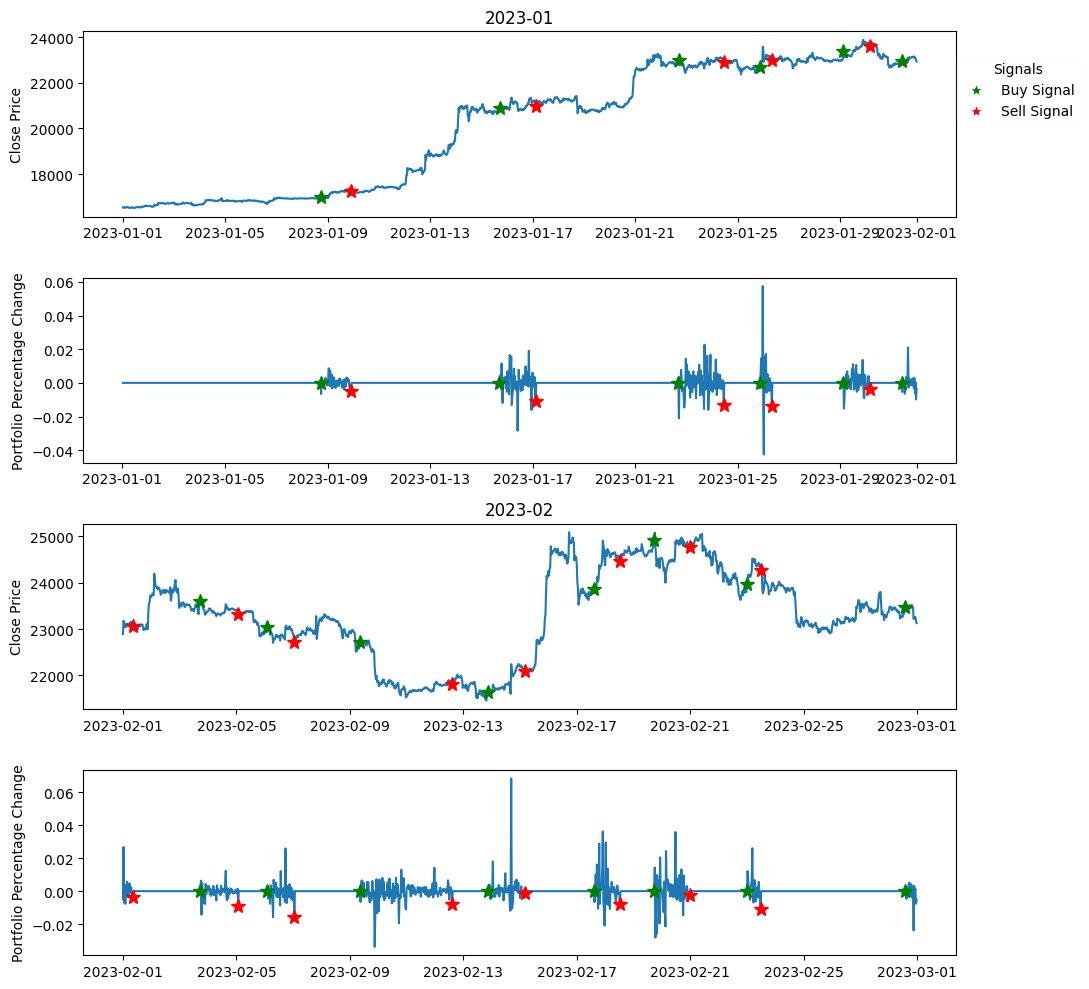

['2023-03' '2023-04']


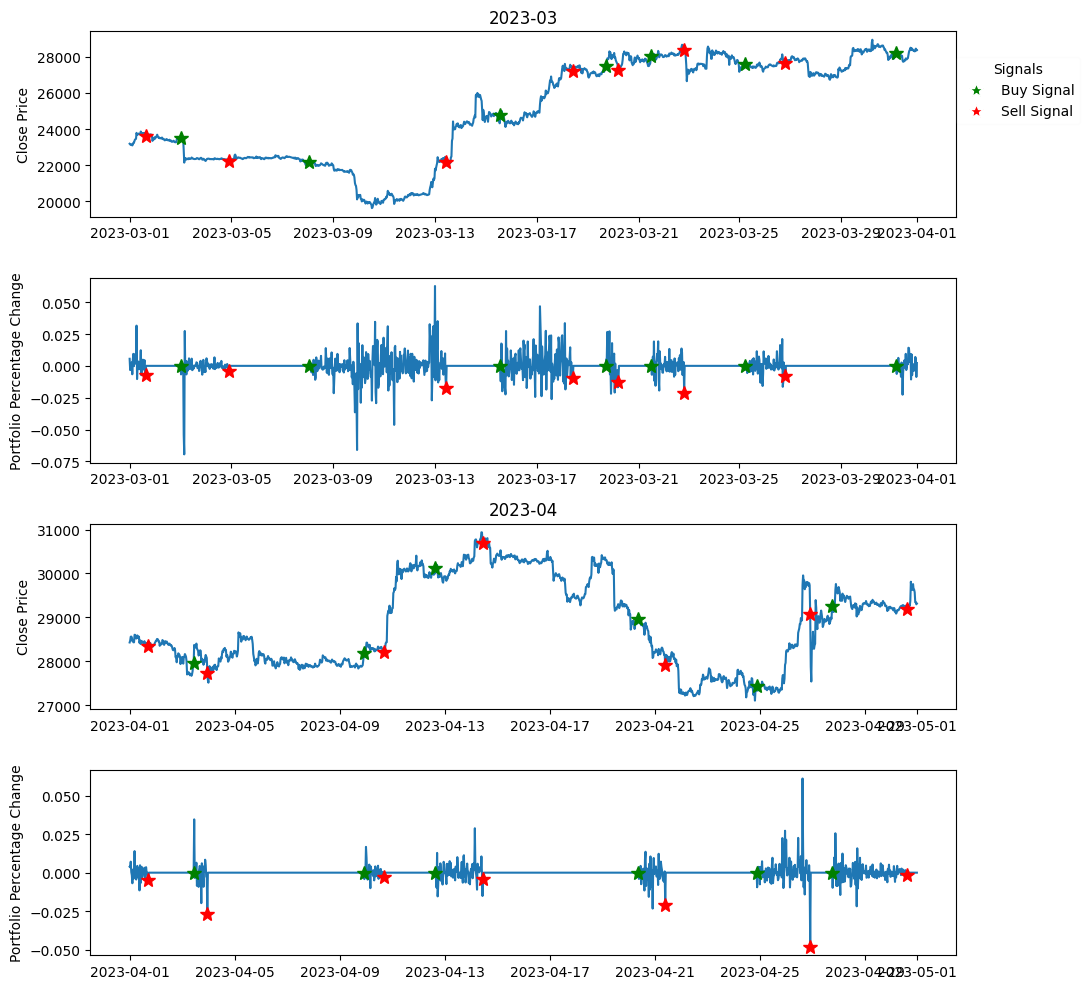

['2023-05' '2023-06']


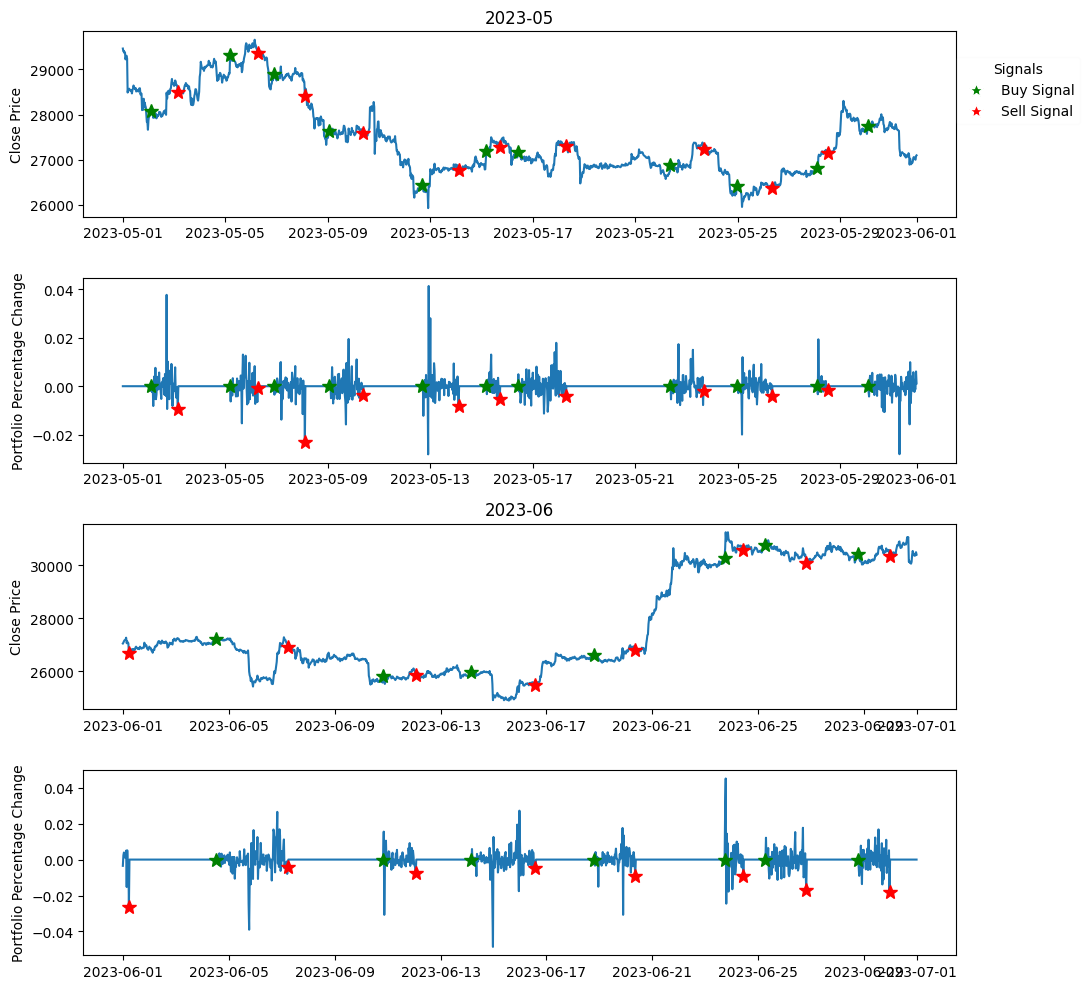

['2023-07' '2023-08']


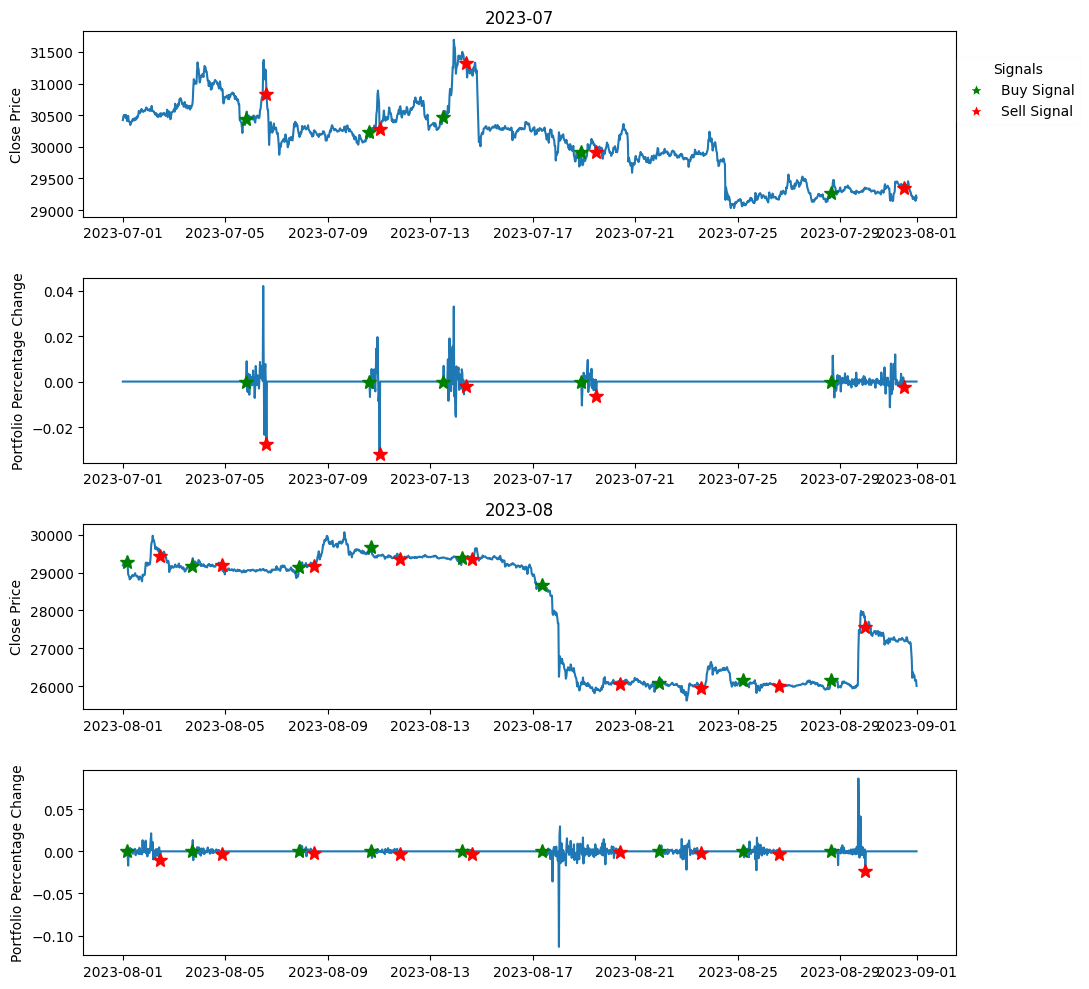

['2023-09' '2023-10']


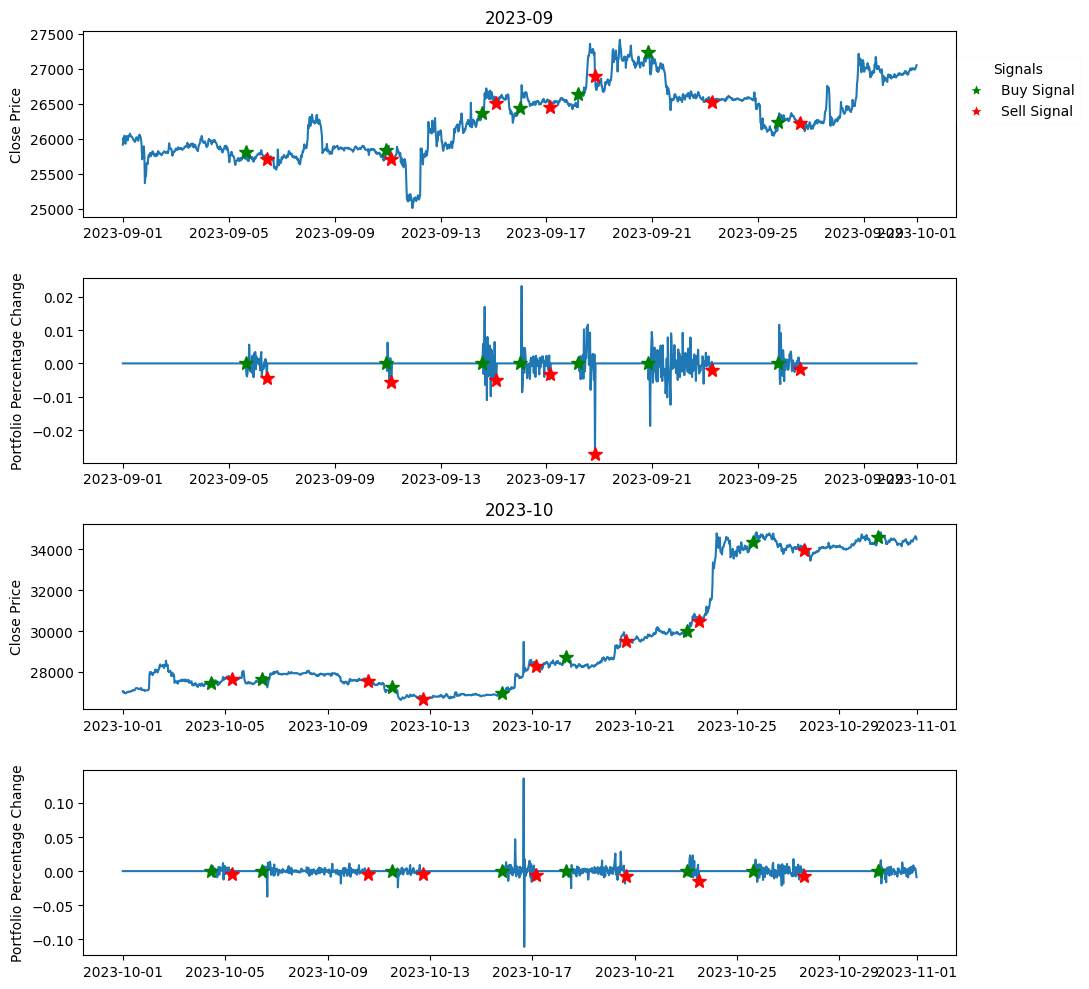

['2023-11' '2023-12']


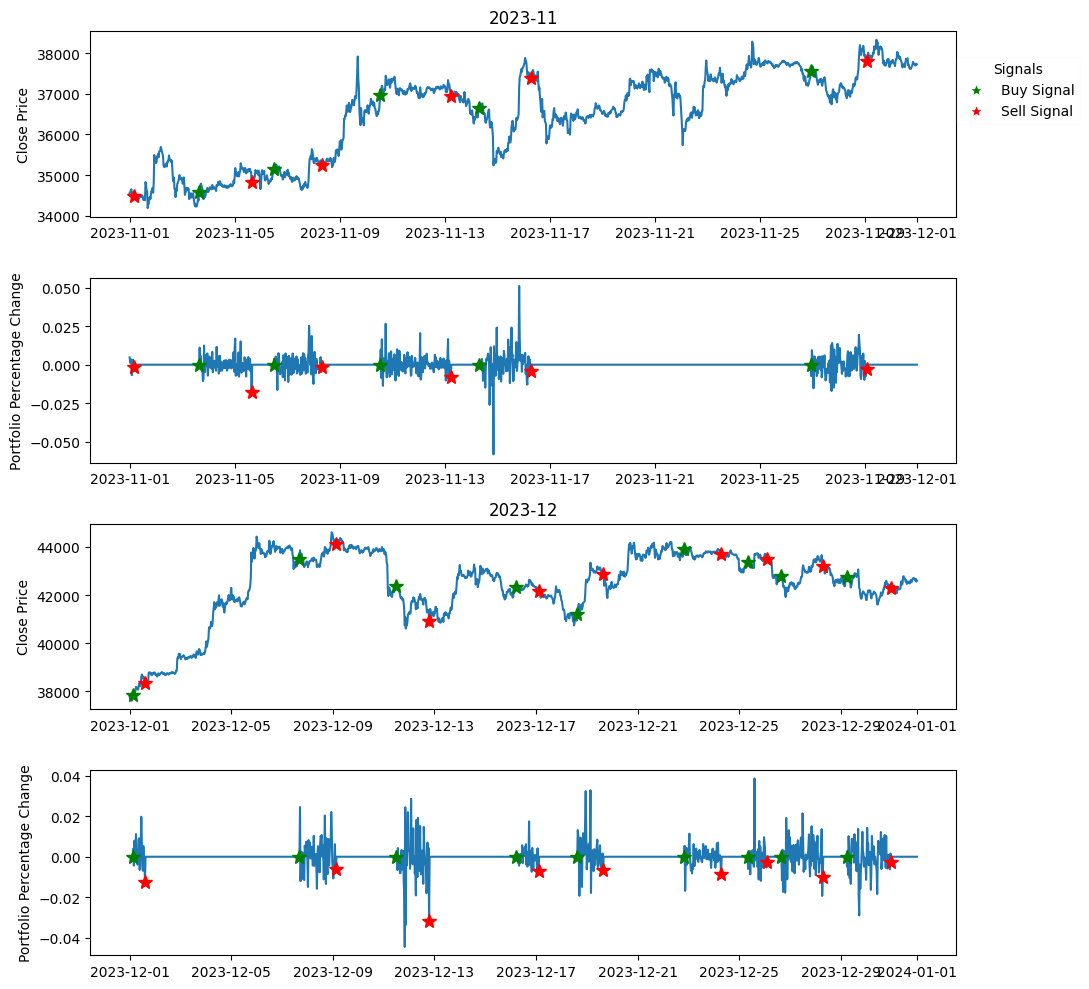

In [13]:
# labeling the rows according to theire month and year for grouping later
btcusdt_df['monthYear'] = btcusdt_df.open_time.apply(lambda x: x.strftime('%Y-%m'))
# handling specific exception of the last row which is alone in its month & year group across the data
btcusdt_df['plotGroup'] = btcusdt_df.open_time.apply(lambda x: (x.year, (x.month-1)//2+1))
btcusdt_df.monthYear.iloc[-1] = btcusdt_df.monthYear.iloc[-2]
btcusdt_df.plotGroup.iloc[-1] = btcusdt_df.plotGroup.iloc[-2]
grouped_df = btcusdt_df.groupby('plotGroup')

# Create subplots for each month & year group


# Defining coloring and labeling in the legend and on the plots
colors = {'BUY': 'g', 'SELL': 'r'}
labels = {'BUY': 'Buy Signal', 'SELL': 'Sell Signal'}
legend_elements = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor=colors['BUY'], markersize=10, label=labels['BUY']),
                   plt.Line2D([0], [0], marker='*', color='w', markerfacecolor=colors['SELL'], markersize=10, label=labels['SELL'])]

for i, (plotGroup, data) in enumerate(grouped_df):
    fig, axs = plt.subplots(4, figsize=(11, 10), sharex=False)
    curMonthYearList = data.monthYear.unique()
    print(curMonthYearList)
    axs[0].plot(data.loc[data.monthYear == curMonthYearList[0],:].open_time, data.loc[data.monthYear == curMonthYearList[0],:].close)
    axs[0].set_title(f'{curMonthYearList[0]}')
    axs[0].set_ylabel('Close Price')
    axs[0].legend(handles=legend_elements, loc=(1,0.5), framealpha=0.05, title='Signals')
    axs[1].plot(data.loc[data.monthYear == curMonthYearList[0],:].open_time, data.loc[data.monthYear == curMonthYearList[0],:].PortfolioPct)
    axs[1].set_ylabel('Portfolio Percentage Change')
    # axs[1].legend(handles=legend_elements, loc=(1,0.5), framealpha=0.05, title='Signals')
    axs[2].plot(data.loc[data.monthYear == curMonthYearList[1],:].open_time, data.loc[data.monthYear == curMonthYearList[1],:].close)
    axs[2].set_title(f'{curMonthYearList[1]}')
    axs[2].set_ylabel('Close Price')
    # axs[2].legend(handles=legend_elements, loc=(1,0.5), framealpha=0.05, title='Signals')
    axs[3].plot(data.loc[data.monthYear == curMonthYearList[1],:].open_time, data.loc[data.monthYear == curMonthYearList[1],:].PortfolioPct)
    axs[3].set_ylabel('Portfolio Percentage Change')
    # axs[3].legend(handles=legend_elements, loc=(1,0.5), framealpha=0.05, title='Signals')
        
    # Adding buy and sell signals
    for j in range(data.shape[0]):
        if data.monthYear.iloc[j] == curMonthYearList[0]:
            if data.Final_signal.iloc[j] == ActionType.BUY:
                axs[0].plot(data.open_time.iloc[j], data.close.iloc[j], marker='*', markersize=10, color=colors['BUY'])
                axs[1].plot(data.open_time.iloc[j], data.PortfolioPct.iloc[j], marker='*', markersize=10, color=colors['BUY'])
            elif data.Final_signal.iloc[j] == ActionType.SELL:
                axs[0].plot(data.open_time.iloc[j], data.close.iloc[j], marker='*', markersize=10, color=colors['SELL'])
                axs[1].plot(data.open_time.iloc[j], data.PortfolioPct.iloc[j], marker='*', markersize=10, color=colors['SELL'])
        else:
            if data.Final_signal.iloc[j] == ActionType.BUY:
                axs[2].plot(data.open_time.iloc[j], data.close.iloc[j], marker='*', markersize=10, color=colors['BUY'])
                axs[3].plot(data.open_time.iloc[j], data.PortfolioPct.iloc[j], marker='*', markersize=10, color=colors['BUY'])
            elif data.Final_signal.iloc[j] == ActionType.SELL:
                axs[2].plot(data.open_time.iloc[j], data.close.iloc[j], marker='*', markersize=10, color=colors['SELL'])
                axs[3].plot(data.open_time.iloc[j], data.PortfolioPct.iloc[j], marker='*', markersize=10, color=colors['SELL'])
    
    plt.tight_layout()
    plt.show()



In [14]:
ActiveStrategy = btcusdt_df.loc[btcusdt_df.Final_signal != ActionType.DONOTHING, :].reset_index(drop = True)
ActiveStrategy['incomeFromStrategy'] = ActiveStrategy.close

for i in range(0, ActiveStrategy.shape[0]//2):
    income = ActiveStrategy.close.iloc[2*i + 1] - ActiveStrategy.close.iloc[2*i]
    ActiveStrategy.incomeFromStrategy.iloc[2*i] = income
    ActiveStrategy.incomeFromStrategy.iloc[2*i + 1] = income

ActiveStrategy = ActiveStrategy.loc[ActiveStrategy.Final_signal == ActionType.SELL, :].reset_index(drop = True)
ActiveStrategyGrouped = ActiveStrategy.groupby('monthYear').agg({'incomeFromStrategy': 'sum'})
ActiveStrategyGrouped

,incomeFromStrategy
monthYear,
2023-01,802.4
2023-02,-231.0
2023-03,1525.2
2023-04,990.5
2023-05,1112.5
2023-06,-1957.3
2023-07,1362.8
2023-08,-1670.6
2023-09,-554.2
